In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D , GlobalMaxPooling2D
from keras.initializers import glorot_uniform,glorot_normal
from keras.models import Model, load_model

Using TensorFlow backend.


In [2]:
DATADIR = "C:/Users/Arpan/Downloads/Education/Project/Rubics Cube/training/"
labels = pd.read_csv(DATADIR+str('labels.csv'))

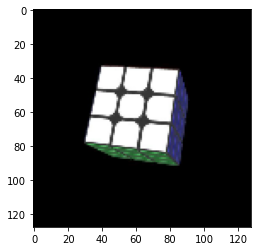

In [3]:
# reducing the sizes
path = DATADIR+str('images')
for img in os.listdir(path):
        img_array = np.array(cv2.imread(os.path.join(path,img)))
        img_size = 128
        new_array = cv2.resize(img_array,(img_size,img_size))
        plt.imshow(new_array)
        plt.show()
        break

In [17]:
path = os.path.join(DATADIR+str('images'))
training_data = []
def create_training_data():    
    for img in os.listdir(path):
        img_array = np.array(cv2.imread(os.path.join(path,img)))
        img_size = 64
        new_array = cv2.resize(img_array,(img_size,img_size))
        training_data.append([new_array, labels.xRot[labels.filename==img].values])

create_training_data()

In [18]:
import random
random.shuffle(training_data)
X =[]
y = []
img_size = 64
for feature,label in training_data:
    X.append(feature)
    y.append(label)

X = np.array(X).reshape(-1,img_size,img_size,3)


In [19]:
y = np.array(y).reshape(-1,1)

In [20]:
import pickle
pickle_out = open('X.pickle','wb')
pickle.dump('X',pickle_out)
pickle_out.close()

pickle_out = open('y.pickle','wb')
pickle.dump('y',pickle_out)
pickle_out.close()

In [21]:
# scaling
X = X/255.

In [22]:
# spilitting the data
train_size = int(0.8 * len(X))
X_train = X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:]
y_test = y[train_size:]

ResNET50


In [23]:
# identity block

def identity_block(X, f, filters, stage, block):
     
    #  name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    #  Filters
    F1, F2, F3 = filters
    
    #  input value. 
    X_shortcut = X
    
    # First main path comp
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    
    # Second main path comp
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component 
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # shortcut
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [24]:
# convolutional block
def convolutional_block(X, f, filters, stage, block, s = 2):
    
    #  name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    #  Filters
    F1, F2, F3 = filters
    
    #  input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component 
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third component 
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # shortcut
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [25]:
# RESNET 50 - Max Pool 

def ResNet50(input_shape=(512, 512, 3), pooling='max'):
    
    # input
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    # Stage 3 
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
    
    if pooling == 'max':
    # MAXPOOL 
        X = MaxPooling2D((2,2), name="max_pool")(X)
    elif pooling == 'avg':
        X = AveragePooling2D((2,2), name="avg_pool")(X)

    # output layer
    X = Flatten()(X)
    X = Dense(1, activation='linear', name='fc', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    #  model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [26]:
model = ResNet50(input_shape=(img_size,img_size,3))

In [27]:
lr_decay = tf.keras.optimizers.schedules.InverseTimeDecay(0.001, decay_steps = 20,
                                                         decay_rate = 2, staircase = True)

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error',metrics=['mean_squared_error'],optimizer=opt)

opt_decay = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error',metrics=['mean_squared_error'],optimizer=opt_decay)

In [15]:
# parameters
epochs = 200
batch_size = 64

In [16]:
history = model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,validation_data=(X_test,y_test))

Train on 4000 samples, validate on 1000 samples
Epoch 1/200
4000/4000 [==============================] - 152s 38ms/step - loss: 2351.1678 - mean_squared_error: 2350.6709 - val_loss: 19920.8730 - val_mean_squared_error: 19920.3691
Epoch 2/200
4000/4000 [==============================] - 115s 29ms/step - loss: 386.0081 - mean_squared_error: 385.5043 - val_loss: 20498.8341 - val_mean_squared_error: 20498.3301
Epoch 3/200
4000/4000 [==============================] - 121s 30ms/step - loss: 278.3554 - mean_squared_error: 277.8521 - val_loss: 21337.5804 - val_mean_squared_error: 21337.0762
Epoch 4/200
3776/4000 [===========================>..] - ETA: 13s - loss: 251.7676 - mean_squared_error: 251.2645

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['val_loss'])
plt.show()

In [ ]:
print(model.evaluate(X_test,y_test))

Trying resnet50 with average pooling

In [ ]:
model2 = ResNet50(input_shape=(64,64,3),pooling='avg')
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model2.compile(loss='mean_squared_error',metrics=['mean_squared_error'],optimizer=opt)

In [ ]:
model2.fit(X_train,y_train,batch_size=batch_size,epochs= epochs,validation_data=(X_test,y_test))

In [ ]:
# max pooling clearly performs better
model2.evaluate(X_test,y_test)

<b>Testing on unknown data

In [ ]:
DATADIR = "C:/Users/Arpan/Downloads/Education/Project/Rubics Cube/"
path = os.path.join(DATADIR+str('images'))
for img in os.listdir(path):
        img_array = np.array(cv2.imread(os.path.join(path,img)))
        img_size = 64
        new_array = cv2.resize(img_array,(img_size,img_size))
        plt.imshow(new_array)
        plt.title(img)
        plt.show()
        break

In [ ]:
DATADIR = "C:/Users/Arpan/Downloads/Education/Project/Rubics Cube/"
path = os.path.join(DATADIR+str('images'))
test_data = []
filename = []
def create_test_data():    
    for img in os.listdir(path):
        img_array = np.array(cv2.imread(os.path.join(path,img)))
        img_size = 64
        new_array = cv2.resize(img_array,(img_size,img_size))
        test_data.append(new_array)
        filename.append(img)

create_test_data()

In [ ]:
X_sub = []
for feature in test_data:
    X_sub.append(feature)

img_size = 64
X_sub = np.array(X_sub).reshape(-1,img_size,img_size,3)
X_sub.shape

In [ ]:
# prediction
X_sub = X_sub/255. #scaling
prediction = model.predict(X_sub)

In [ ]:
prediction[:20]

### Making submission

In [ ]:
submission = pd.DataFrame(filename, columns=['filename'])
submission['xRot'] = prediction
submission.head()

In [ ]:
submission.to_csv('submission_Rubics2.csv',index = False) - #0.27 MSE